## Van Gogh and other artist
This notebook is dedicated for running generic pipeline on Colab, kaggle token is required for dataset download.

1. Clone the repository to your colab area:

In [ ]:
!git clone https://github.com/czkaiweb/vanGogh-and-Other-Artist.git

# To fetch the change from git repo
%cd /content/vanGogh-and-Other-Artist
!git fetch 
!git pull
#!git checkout develop
%cd /content



Cloning into 'vanGogh-and-Other-Artist'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 84 (delta 37), reused 62 (delta 21), pack-reused 0
Unpacking objects: 100% (84/84), done.
/content/vanGogh-and-Other-Artist
Already up to date.
/content


2. Import the files and needed packages:

In [ ]:
import sys
sys.path.append('/content/vanGogh-and-Other-Artist')
sys.path.append('/content/vanGogh-and-Other-Artist/preprocessing')
sys.path.append('/content/vanGogh-and-Other-Artist/model')
from genericCNN import *
from preprocessing.ImageTranform import *
from torchsummary import summary

import shutil
import os
import glob
import pandas as pd
import numpy
from tqdm import tqdm
import hashlib

from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

%load_ext autoreload
%autoreload 2

3.Create image output folder:

In [ ]:
# Create Meta record
fileList = []
img_path = "./imgs"

if not os.path.isdir(img_path):
    os.mkdir(img_path)

4. Setup Kaggle token file:

In [ ]:
kaggle_path = "/root/.kaggle"
if not os.path.isdir(kaggle_path):
  os.mkdir(kaggle_path)


5. In the left column, click "File", go to parent folder, check if  /root/.kaggle is existed. Upload your kaggle token file (usually it is named kaggle.json) there.
Using "chmod" to set proper authentication to protect your token

In [ ]:
mv /root/kaggle.json /root/.kaggle/

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

6. Download the van gogh dataset, unzip the dataset and append the meta data:

In [ ]:
# Download van Gogh dataset
!kaggle datasets download -d ipythonx/van-gogh-paintings

# List all von Goph plots
tmp_path = "./tmp"
vangoghZip = 'van-gogh-paintings.zip'
try:
    shutil.unpack_archive(vangoghZip,tmp_path)
except Exception as err:
    print(err)

allVanGogh = glob.glob(tmp_path+'/*/*.jpg')

# Append metadata
for index in tqdm(range(len(allVanGogh))):
    fileName = allVanGogh[index]
    file = fileName.split("/")[-1]
    hashName = hashlib.md5(file.encode()).hexdigest()
    shutil.move(fileName, img_path + "/" + hashName + ".jpg", copy_function = shutil.copy2)
    artist = "vanGogh"
    fileList.append([hashName,artist])
    
# Clean tmp data
try:
    shutil.rmtree(tmp_path)
    os.remove(vangoghZip)
except Exception as err:
    print(err)

 95% 461M/485M [00:04<00:00, 150MB/s]
100% 485M/485M [00:04<00:00, 118MB/s]


100%|██████████| 2024/2024 [00:00<00:00, 20622.85it/s]


7. Download the monet dataset, unzip the dataset and append the meta data:

In [ ]:
!kaggle datasets download -d srrrrr/monet2photo

# List all Monet plots
tmp_path = "./tmp"
monetZip = 'monet2photo.zip'
try:
    shutil.unpack_archive(monetZip,tmp_path)
except Exception as err:
    print(err)

allMonet = glob.glob(tmp_path+'/*/trainA/*.jpg')

# Append metadata
for index in tqdm(range(len(allMonet))):
    fileName = allMonet[index]
    file = fileName.split("/")[-1]
    hashName = hashlib.md5(file.encode()).hexdigest()
    shutil.move(fileName, img_path + "/" + hashName + ".jpg", copy_function = shutil.copy2)
    artist = "Monet"
    fileList.append([hashName,artist])
    
# Clean tmp data
try:
    shutil.rmtree(tmp_path)
    os.remove(monetZip)
except Exception as err:
    print(err)

 92% 242M/263M [00:01<00:00, 209MB/s]
100% 263M/263M [00:01<00:00, 183MB/s]


100%|██████████| 1072/1072 [00:00<00:00, 37053.19it/s]


8. Download the customized dataset, unzip the dataset and append the meta data:

In [ ]:
# Download WikiArts dataset: https://www.kaggle.com/datasets/antoinegruson/-wikiart-all-images-120k-link
!kaggle datasets download -d czkaiweb/subwikiarts

# List all wikiarts plots
tmp_path = "./tmp"
wikiartsZip = 'subwikiarts.zip'
try:
    shutil.unpack_archive(wikiartsZip,tmp_path)
except Exception as err:
    print(err)

WikiArtsMeta = tmp_path+"/WikiArts.csv"
WikiArtsDF = pd.read_csv(WikiArtsMeta)
WikiArtsList = WikiArtsDF[["hash","Artist"]].values

def findGroup(head):
    if head <= "33":
        return "/GroupA/"
    elif head <= "69":
        return "/GroupB/"
    elif head <= "9d":
        return "/GroupC/"
    elif head <= "cc":
        return "/GroupD/"
    else:
        return "/GroupE/"
    
# Set to true for group splitting
preClean = False
if preClean == True:
    for char in ["A","B","C","D","E"]:
        groupDir = img_path+"/Group{}".format(char)
        if not os.path.isdir(groupDir):
            os.mkdir(groupDir)

for record in WikiArtsList:
    groupDir = "/./"
    if preClean:
        groupDir = findGroup(record[0][:2])
    fileName = tmp_path+"/imgs/"+record[0]+".jpg"
    shutil.move(fileName, img_path+ groupDir + "/" , copy_function = shutil.copy2)
    
# Clean tmp data
try:
    shutil.rmtree(tmp_path)
    os.remove(wikiartsZip)
except Exception as err:
    print(err)


 99% 985M/995M [00:06<00:00, 191MB/s]
100% 995M/995M [00:06<00:00, 149MB/s]


9. Create the csv file for meta data:

In [ ]:
# Save to meta file
metaDF = pd.DataFrame(fileList,columns = ["hash","Artist"])
metaDF = pd.concat([metaDF,WikiArtsDF[["hash","Artist"]]])
metaDF.to_csv("meta.csv")

10. Import the generic pipeline and transformer if not imported yet, set the image transformer to the genericCNN

In [ ]:
#Initialize the object
myObj = genericCNN()

# Set up the transformer
myTransform = ImageTransformer((224,224))
myTransform.initTransform()
transformer = myTransform.getTransformer()

myObj.setTransformer(transformer)
# Decide if adding normalization layer at the end of transformation, by default, normalization will be added
# myObj.UseNormalized(normalize = True)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1421: UserWarning: The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. Please use 'interpolation' instead.
  "The parameter 'resample' is deprecated since 0.12 and will be removed in 0.14. "
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:1436: UserWarning: The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. Please use 'fill' instead.
  "The parameter 'fillcolor' is deprecated since 0.12 and will be removed in 0.14. "


11. Set meta data and input path, split the dataset and load the data to Dataset/DatasetLoader

In [ ]:
# Set up the meta data and path to image dataset
myObj.setDataset("meta.csv",path = "imgs")

# Split the data by portion, fraction indicate the percentage of data used in the whole dataset. 
# Default: val_size = 0.2, test_size = 0.1 
#myObj.splitData(val_size=0.2,test_size = 0.1,fraction = 1)
myObj.splitData(val_size=0.1,test_size = 0.7,fraction = 1)

# Will automatically get the statistic for training set, update the mean/std used for normalization. 
# loadData and checkDataset
#myObj.loadData()
myObj.loadData(reUseTrain=3)


53e872e09c40a912e36d53daf6920243 torch.Size([4, 224, 224])
53e872e09c40a912e36d53daf6920243 torch.Size([4, 224, 224])
53e872e09c40a912e36d53daf6920243 torch.Size([4, 224, 224])
0641ceb25ff823cf52802ea8c07558b1 torch.Size([1, 224, 224])
ee7c58e67dabd4b7459bddf9f669f707 torch.Size([1, 224, 224])
84e717a6cf749d681ffbb2557758bd13 torch.Size([1, 224, 224])
7dc6002a966d35a49f263376c2a56256 torch.Size([1, 224, 224])
8c9f5633d217a54f78ed5f2146324b38 torch.Size([1, 224, 224])
632fc73d4e2de07f28d85429ff390476 torch.Size([1, 224, 224])
b96a4a83299a54b4be4ff78c0d92c170 torch.Size([1, 224, 224])
a2bbef5813e42924f2168bef12a26478 torch.Size([4, 224, 224])
9d694f7ee70d5f694dda849a0a132bcb torch.Size([4, 224, 224])
d7999f4ec0a7efcc004c733e813ddb39 torch.Size([4, 224, 224])
0be2cd049d2ecf361c6ffcb1c5054de5 torch.Size([4, 224, 224])
e2ee5d0fd45f95074b7e5e8665ab22de torch.Size([4, 224, 224])
bcbf898f298ba2a00e088c50e3e27134 torch.Size([1, 224, 224])
e5f0411ee34ba439116a0d8d8cfe64c3 torch.Size([1, 224, 224

12. Display a batch:

0 torch.Size([5, 3, 224, 224]) tensor([1, 4, 4, 1, 2])
torch.Size([5, 3, 224, 224])


<Figure size 432x288 with 0 Axes>

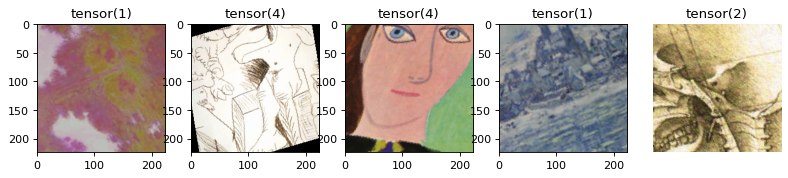

In [ ]:
myObj.showDatasetBatch()

13. Select model and edit the architecture:

In [ ]:
# Use the pre-trained model
#model_ft.load_state_dict(torch.load('./weights/vgg16-397923af.pth'))
#model_ft = models.googlenet(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc=nn.Linear(num_ftrs, 6)

model_ft = models.mobilenet_v2(pretrained=True)
num_ftrs = model_ft.classifier[1].in_features
model_ft.classifier[1] = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(myObj.device)

# Specifiy the criterion:
criterion = nn.CrossEntropyLoss()

# Specify the optizimer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Specift the learning rate scheduler. Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

14. Set the model for the generic object:

In [ ]:
#myObj.setModel(model = model_ft,modeltag="googlenet")
myObj.setModel(model = model_ft,modeltag="mobilenet_v2")

15: Train the model:

In [ ]:
myObj.train_model(criterion, optimizer_ft, exp_lr_scheduler, num_epochs=14)

Epoch 0/13
----------


Epoch 0 Phase train: 100%|██████████| 682/682 [02:31<00:00,  4.50batch/s]


train Loss: 1.2015 Acc: 0.5725


Epoch 0 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.11batch/s]


val Loss: 2.0103 Acc: 0.4690

Epoch 1/13
----------


Epoch 1 Phase train: 100%|██████████| 682/682 [02:30<00:00,  4.54batch/s]


train Loss: 0.9277 Acc: 0.6705


Epoch 1 Phase val: 100%|██████████| 113/113 [00:16<00:00,  6.85batch/s]


val Loss: 1.8963 Acc: 0.5416

Epoch 2/13
----------


Epoch 2 Phase train: 100%|██████████| 682/682 [02:26<00:00,  4.67batch/s]


train Loss: 0.7954 Acc: 0.7160


Epoch 2 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.13batch/s]


val Loss: 1.2781 Acc: 0.6850

Epoch 3/13
----------


Epoch 3 Phase train: 100%|██████████| 682/682 [02:30<00:00,  4.55batch/s]


train Loss: 0.7132 Acc: 0.7550


Epoch 3 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.11batch/s]


val Loss: 1.4431 Acc: 0.6496

Epoch 4/13
----------


Epoch 4 Phase train: 100%|██████████| 682/682 [02:32<00:00,  4.46batch/s]


train Loss: 0.6427 Acc: 0.7729


Epoch 4 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.09batch/s]


val Loss: 0.5808 Acc: 0.8195

Epoch 5/13
----------


Epoch 5 Phase train: 100%|██████████| 682/682 [02:26<00:00,  4.64batch/s]


train Loss: 0.6037 Acc: 0.7952


Epoch 5 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.20batch/s]


val Loss: 0.9170 Acc: 0.7009

Epoch 6/13
----------


Epoch 6 Phase train: 100%|██████████| 682/682 [02:31<00:00,  4.49batch/s]


train Loss: 0.5566 Acc: 0.8099


Epoch 6 Phase val: 100%|██████████| 113/113 [00:16<00:00,  7.05batch/s]


val Loss: 0.7584 Acc: 0.7752

Epoch 7/13
----------


Epoch 7 Phase train: 100%|██████████| 682/682 [02:26<00:00,  4.65batch/s]


train Loss: 0.3484 Acc: 0.8765


Epoch 7 Phase val: 100%|██████████| 113/113 [00:16<00:00,  7.05batch/s]


val Loss: 0.5909 Acc: 0.8000

Epoch 8/13
----------


Epoch 8 Phase train: 100%|██████████| 682/682 [02:28<00:00,  4.59batch/s]


train Loss: 0.2947 Acc: 0.8950


Epoch 8 Phase val: 100%|██████████| 113/113 [00:16<00:00,  6.93batch/s]


val Loss: 0.5164 Acc: 0.8407

Epoch 9/13
----------


Epoch 9 Phase train: 100%|██████████| 682/682 [02:26<00:00,  4.67batch/s]


train Loss: 0.2900 Acc: 0.9064


Epoch 9 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.07batch/s]


val Loss: 0.5302 Acc: 0.8301

Epoch 10/13
----------


Epoch 10 Phase train: 100%|██████████| 682/682 [02:27<00:00,  4.63batch/s]


train Loss: 0.2659 Acc: 0.9105


Epoch 10 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.08batch/s]


val Loss: 0.5479 Acc: 0.8265

Epoch 11/13
----------


Epoch 11 Phase train: 100%|██████████| 682/682 [02:30<00:00,  4.55batch/s]


train Loss: 0.2546 Acc: 0.9134


Epoch 11 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.10batch/s]


val Loss: 0.5623 Acc: 0.8283

Epoch 12/13
----------


Epoch 12 Phase train: 100%|██████████| 682/682 [02:31<00:00,  4.50batch/s]


train Loss: 0.2250 Acc: 0.9266


Epoch 12 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.15batch/s]


val Loss: 0.4862 Acc: 0.8655

Epoch 13/13
----------


Epoch 13 Phase train: 100%|██████████| 682/682 [02:32<00:00,  4.49batch/s]


train Loss: 0.2315 Acc: 0.9258


Epoch 13 Phase val: 100%|██████████| 113/113 [00:15<00:00,  7.13batch/s]

val Loss: 0.4784 Acc: 0.8619

Training complete in 38m 36s
Best val Acc: 0.865487


MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

16. Evaluate the model:

17. Save the weights as pth file:

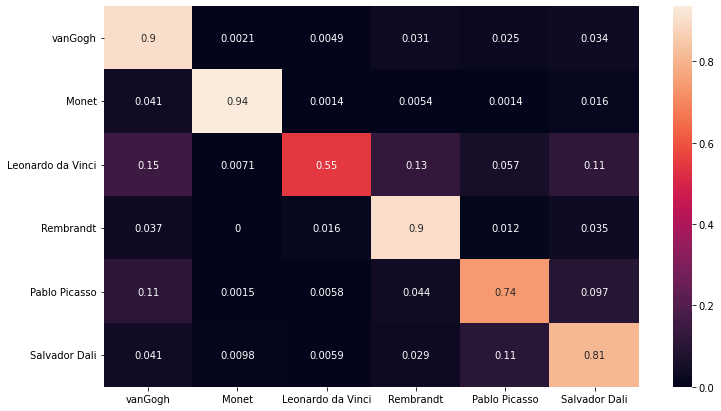

In [ ]:
myObj.evaluate()

In [ ]:
torch.save(myObj.Model.state_dict(), 'model_weights.pth')

18. Download the weight file from colab:

In [ ]:
from google.colab import files
files.download("model_weights.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>